In [8]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/kenzeng24/social-network-url-clustering.git
import sys
sys.path.append('social-network-url-clustering')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'social-network-url-clustering' already exists and is not an empty directory.


In [9]:
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup
from collections import defaultdict
import nltk
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
from nltk.tokenize import word_tokenize
nltk_tokenizer = TreebankWordTokenizer()
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# # breaks text into tokens 
# nltk_tokenizer = TreebankWordTokenizer()
# tokenized_text = [] 
# for line in lines:
#     for sent in sent_tokenize(line):
#         tokenized_text += nltk_tokenizer.tokenize(sent)
#         # TODO: remove stopwords and lemmatize 
# print(len(tokenized_text))

In [ ]:
#!ls drive/MyDrive/CDS_Capstone_2022_Fall/data/

In [11]:
from nltk.sem.relextract import NE_CLASSES

from src.data_loading.interactions import ROOT

# match HTML link to MBFC label 
metadata = pd.read_json(os.path.join(ROOT, 'data/capstone_url_metadata.json'))
metadata_hc = pd.read_json(os.path.join(ROOT, 'data/capstone_url_metadata_hc.json'))
metadata_hc['domain'] = metadata_hc['url'].apply(
        lambda x: x.replace('https://www.', '').split('/', 1)[0]
    )
df_meta = pd.concat([metadata, metadata_hc])
df_mbfc = pd.read_csv(os.path.join(ROOT, 'data/mbfc.csv'))
#Score: 1 for Low credibility, -1 for Medium to High Credibility
df_mbfc['label'] = df_mbfc['r'].map({"VH" : -1, "H" : -1,"MF" : 1, "M" : 1,"L" : 1,"VL" : 1})
combined_metadata = pd.merge(df_meta, df_mbfc[['domain', 'label']], how='left', on='domain')

# 1. check how many ids have an HTML txt file 
html_data_path = 'drive/MyDrive/CDS_Capstone_2022_Fall/data/data_with_html/data_with_html'

# all filennames have this format: "{}/{}/{}.json".format(html_data_path, id[:3], id)  

# 2. extract tokenized text using the following function (need to fix)
#Look at which domains are most popular to gather the text components 
#create a new parsed.txt file
def opent_txt_file(id):
    tokenized_text = [] 
    filename = "{}/{}/{}.txt".format(html_data_path, id[:3], id)  
    #[''.join for line in fileobject] ; 
    #([for line in fileobject]).join(‘ ’)
    with open(os.path.join(filename)) as fileobject:
        for line in fileobject:
          #change to nontokenized format; remove paragraph spaces
            for sent in sent_tokenize(line):
                tokenized_text += nltk_tokenizer.tokenize(sent)
    return tokenized_text 

def open_alltxt_file(id):
    new_list=[]
    filename = "{}/{}/{}.txt".format(html_data_path, id[:3], id)  
    #[''.join for line in fileobject] ; 
    #([for line in fileobject]).join(‘ ’)
    with open(os.path.join(filename)) as fileobject:
        return ' '.join([line.replace('\n', '') for line in fileobject])
#remove htmls in text
# 3: convert tokenized text to TFIDF vectors
        

In [ ]:
metadata.columns

Index(['url', 'created_at', 'domain', 'id_hash256', 'interaction',
       'num_platform'],
      dtype='object')

In [ ]:
metadata_hc.columns

Index(['url', 'id_hash256', 'domain'], dtype='object')

In [ ]:
np.array(metadata.id_hash256)[0]

'1aec1751d79ce05c57ea0d78218e1042c9861713c023a7c362cbbc0a74cd10fc'

In [ ]:
if '000bc553fae987c65e3bd7328f0327f7d8c6c66f563622f8975e6032f2ccb5f3' in np.array(metadata.id_hash256):
  print('yes')
else:
  print('no')

yes


In [ ]:
combined_metadata.columns

Index(['url', 'created_at', 'domain', 'id_hash256', 'interaction',
       'num_platform', 'label'],
      dtype='object')

Create script to check missing urls https://archive.org/developers/. https://web.archive.org/web/20220000000000*/https://www.reddit.com/r/SouthwestAirlines/comments/zw32yt/psa_from_a_swa_employee_since_the_company_wont/ 

In [12]:
balanced_dataset=pd.read_csv('drive/MyDrive/CDS_Capstone_2022_Fall/data/upsampled_urls.csv')

In [8]:
#try with full balanced_dataset
sample_metadata=balanced_dataset.sample(n=25000, random_state=5)
len(sample_metadata)

25000

In [13]:
%%time 
id_text_df={} #defaultdict(list)
missing_content=[]
fail=0

for id in np.array(balanced_dataset.id_hash256):
  try:
    id_text_df[id]=open_alltxt_file(id)
  except Exception as e:
    #some don't have txt file; html missing from url; for those that can't be traced on webarchive, remove from our set 
    missing_content.append(id)
    fail+=1
    #print(f'An error occurred on id: {id[:3]}')

#this took 6 hours and 27 min to fully run for me; had 19k+ fails
print(f'total fail: {fail}')

#separate out the ids with missing text; gather corresponding text with internet archive
calculated_df=pd.DataFrame(id_text_df, index=[0])
id_text_ndf=calculated_df.T.reset_index()
id_text_ndf.rename(columns={'index':'id_hash256', 0:'extract_text'},inplace=True)
id_text_ndf
new_merge=pd.merge(id_text_ndf, metadata, how="inner", on='id_hash256')


total fail: 34402
CPU times: user 30.5 s, sys: 11 s, total: 41.5 s
Wall time: 1h 53min 38s


In [14]:
new_merge.extract_text=new_merge.extract_text.str.replace('|','')
new_merge.head()

<ipython-input-14-e4c8729644ad>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_merge.extract_text=new_merge.extract_text.str.replace('|','')


,id_hash256,extract_text,url,created_at,domain,interaction,num_platform
0,1aec1751d79ce05c57ea0d78218e1042c9861713c023a7...,UK Energy Crisis Could Be Worse Than 2008 Fina...,summit.news/2022/08/26/uk-energy-crisis-could-...,2022-08-31 23:56:01.274,summit.news,"{'facebook': 0, 'retweet': 537, 'reply': 618, ...",2
1,a26fec754e7e97dd15f0c82d6beaa6fcdaf11e55bf9753...,Rove calls out Biden's declaration of Trumpism...,rumble.com/v1heend-rove-calls-out-bidens-decla...,2022-08-31 23:39:22.867,rumble.com,"{'facebook': 0, 'retweet': 0, 'reply': 0, 'red...",1
2,e576587fedff32407a2a630cf85dec43a610bac951adbb...,Joe Biden: I Respect 'Conservative' Republican...,breitbart.com/politics/2022/08/25/joe-biden-i-...,2022-08-31 23:36:30.077,breitbart.com,"{'facebook': 14, 'retweet': 264, 'reply': 1650...",3
3,261b08f446cdd8866ab06b7e06e4be656b32ae8fb042f2...,FBI blasted after Zuckerberg revealed their wa...,foxnews.com/media/fbi-blasted-after-zuckerberg...,2022-08-31 23:24:21.126,foxnews.com,"{'facebook': 4566, 'retweet': 3073, 'reply': 4...",4
4,d88aef691232cf96555599e27fee97cbb8874cb1f2e084...,FBI is a branch of the Democratic Party FBI is...,rumble.com/v1hectr-fbi-is-a-branch-of-the-demo...,2022-08-31 23:22:37.291,rumble.com,"{'facebook': 0, 'retweet': 0, 'reply': 0, 'red...",1


In [15]:
new_merge.to_csv(ROOT+'/data/ids_withtext.csv', escapechar='\\') #ids with text

c_merge=new_merge.groupby(['domain'])['id_hash256'].count()
c_merge=c_merge.to_frame()
c_merge=c_merge.reset_index()
sort_merge=c_merge.sort_values(by='id_hash256', ascending=False)
sort_merge.to_csv(ROOT+'/data/textranked_domains.csv')

In [16]:
missing_text_urls=pd.DataFrame({"missing_text":missing_content})
missing_text_urls.to_csv(ROOT+'/data/missing_idtext.csv')
missing_df=pd.read_csv(os.path.join(ROOT, 'data/missing_idtext.csv'))
missing_df.rename(columns={'missing_text':'id_hash256'},inplace=True)

In [17]:
miss_merge=pd.merge(missing_df, metadata, how="inner", on='id_hash256')

Some of the sites exist but they are in video format, so we couldn't get their text

In [16]:
miss_merge.head(2)

,Unnamed: 0,id_hash256,url,created_at,domain,interaction,num_platform
0,0,043173875ada47d781b985812f22078a7571862f93b6a6...,theepochtimes.com/lara-logan-quitting-big-tech...,2022-02-07 10:32:01.411,theepochtimes.com,"{'facebook': 0, 'retweet': 0, 'reply': 0, 'red...",2
1,1,41fd726a8b80a917b5c884d1ab9308590d98774f0c7759...,dailymail.co.uk/news/article-10675553/Transgen...,2022-04-02 01:43:05.623,dailymail.co.uk,"{'facebook': 1965, 'retweet': 6734, 'reply': 7...",5


In [18]:
miss_merge['url'].to_csv(ROOT+'/data/missingtext_urls.csv')
#TODO: Merge with existing labels
missingurls_df=pd.read_csv(os.path.join(ROOT,'data/missingtext_urls.csv'))
#missingurls_df
labeled_missing=pd.merge(missingurls_df, combined_metadata, how='inner', on='url')
labeled_missing.head()

,Unnamed: 0,url,created_at,domain,id_hash256,interaction,num_platform,label
0,0,djhjmedia.com/steven/alabama-ess-voting-machin...,2022-08-31 23:42:47.618,djhjmedia.com,7da05e85a95a0d8bda9df805d87163785565da3fd59a0b...,"{'facebook': 3, 'retweet': 161, 'reply': 145, ...",2.0,1.0
1,1,americanthinker.com/articles/2022/08/the_senat...,2022-08-31 22:53:55.353,americanthinker.com,d686e1e838b0fc9bda4854adfda5a004274bf2d7b7041c...,"{'facebook': 9, 'retweet': 0, 'reply': 0, 'red...",1.0,1.0
2,2,breitbart.com/europe/2022/08/26/at-least-30000...,2022-08-31 22:48:13.566,breitbart.com,6dcb7a5dda1d152d069e2b1b6c5b84f66a9f97440d27f9...,"{'facebook': 92, 'retweet': 440, 'reply': 528,...",2.0,1.0
3,3,expose-news.com/2022/08/26/the-birth-of-a-worl...,2022-08-31 22:23:12.220,expose-news.com,e158a866d5e6389fd5f6255fc71dc800da25314ee97981...,"{'facebook': 9, 'retweet': 0, 'reply': 0, 'red...",1.0,1.0
4,4,zerohedge.com/markets/doomsday-scenario-70-bri...,2022-08-31 22:20:33.065,zerohedge.com,3d0c97901f1383e60c6b26ae6572edc480bc44f394be49...,"{'facebook': 0, 'retweet': 46378, 'reply': 179...",3.0,1.0


In [19]:
#TODO: Merge with existing labels
id_textexistingurls_df=pd.read_csv(os.path.join(ROOT,'data/ids_withtext.csv'))

labeled_existing=pd.merge(id_textexistingurls_df[['url','extract_text','domain','id_hash256']], combined_metadata[['url','id_hash256','created_at','num_platform','domain','label']], how='inner', on=['url','id_hash256','domain'])
labeled_existing.head()

labeled_existing.to_csv(ROOT+'/data/labeled_existing.csv')

##IGNORE BOTTOM (SCRATCH WORK)

In [19]:
combined_metadata.columns

Index(['url', 'created_at', 'domain', 'id_hash256', 'interaction',
       'num_platform', 'label'],
      dtype='object')

In [ ]:
id_textexistingurls_df.columns

Index(['Unnamed: 0', 'id_hash256', 'extract_text', 'url', 'created_at',
       'domain', 'interaction', 'num_platform'],
      dtype='object')

In [ ]:
print(len(labeled_missing))
labeled_missing.isna().sum() 

7400


Unnamed: 0         0
url                0
created_at         0
domain             0
id_hash256         0
interaction        0
num_platform       0
label           1680
dtype: int64

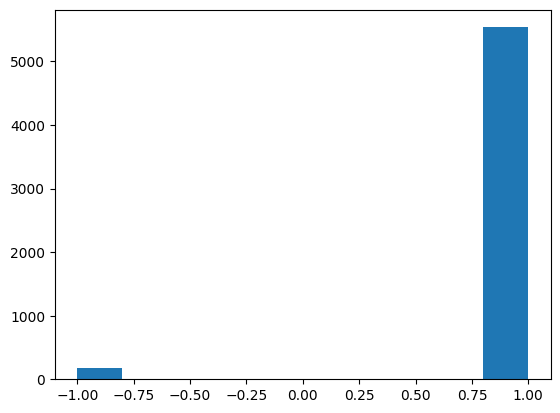

In [ ]:
import matplotlib.pyplot as plt
plt.hist(labeled_missing['label'])
plt.show()

In [ ]:
miss_merge['url'].values.tolist()

['bitchute.com/video/sk49VrKQx3TL',
 'foxnews.com/us/missouri-shopper-shoots-kills-armed-robber-holding-knife-clerks-neck',
 'theepochtimes.com/twitter-reinstates-doctor-it-suspended-for-sharing-study-that-shows-pfizer-vaccine-impacts-semen_4600390.html',
 'naturalnews.com/2022-08-17-thai-study-young-adults-injured-covid-vaccines.html',
 'breitbart.com/politics/2022/05/10/democrats-aim-to-spend-60b-more-taxpayer-dollars-during-40-year-high-inflation',
 'fema.gov/event/national-engagement-seminar-planning-guidance-response-nuclear-detonation',
 'babylonbee.com/news/americans-who-cowered-under-government-oppression-for-2-years-urge-ukrainians-to-die-for-freedom',
 'townhall.com/columnists/allenwest/2022/04/11/race-and-american-exceptionalism-n2605734',
 'westernstandardonline.com/2022/03/woke-home-depot-shaming-staff-for-their-white-privilege',
 'breitbart.com/clips/2022/01/12/ron-johnson-on-inflation-this-didnt-just-happen-this-is-caused-by-democrat-policies',
 'revolver.news/2022/01/wh

In [ ]:
#id_text_ndf.to_csv(ROOT+'/data/sample_idtext.csv')
#id_text_df['000bc553fae987c65e3bd7328f0327f7d8c6c66f563622f8975e6032f2ccb5f3']

In [ ]:
idtext=pd.read_csv(r'drive/MyDrive/CDS_Capstone_2022_Fall/data/sample_idtext.csv')
idtext.head()

,Unnamed: 0,id_hash256,extract_text
0,0,545bed78bd69984d0d269babf05a49b66138500361aace...,Jan. 6 Prisoner Simone Gold Claims She Rejecte...
1,1,9c4edaf00d8d208e4b3779eb7c149f83d3882c9c24ddd8...,Nunes: Truth Social expands to UK to reclaim I...
2,2,1c6f01b2dbc8ae8432b6090a1ce3d5c6375dd038d1f7b8...,Harriet Hageman outlines how she will oust Liz...
3,3,6688cb68c1745eaa6aabf73ba5ebd9d66d3f0458bfdb2f...,'I'm A Pedophile': Biden-Era USPS Chief in Mai...
4,4,520e02def479c4e06eb609a874f31e037cd7dc8dddd39e...,"""We Have One of the Best Militaries in the Wor..."


In [ ]:
#Use capstone_url_metadata_hc json file

In [ ]:
cmetadata=pd.read_csv(r'drive/MyDrive/CDS_Capstone_2022_Fall/data/combined_metadata.csv')
cmetadata.head()

<ipython-input-4-5408f91a8685>:1: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  cmetadata=pd.read_csv(r'drive/MyDrive/CDS_Capstone_2022_Fall/data/combined_metadata.csv')


,Unnamed: 0,url,created_at,domain,id_hash256,interaction,num_platform,label
0,0,summit.news/2022/08/26/uk-energy-crisis-could-...,2022-08-31 23:56:01.274,summit.news,1aec1751d79ce05c57ea0d78218e1042c9861713c023a7...,"{'facebook': 0, 'retweet': 537, 'reply': 618, ...",2.0,1.0
1,1,voxday.net/2022/08/26/gavin-mcinnes-arrested,2022-08-31 23:47:49.682,voxday.net,948cf82870f2d99ad54eb77bd4ccf807e74069682c6112...,"{'facebook': 0, 'retweet': 0, 'reply': 0, 'red...",1.0,NaN
2,2,kanekoa.substack.com/p/investigation-into-us-e...,2022-08-31 23:47:25.920,kanekoa.substack.com,ce09d73e69161fb8e6e35f99edadb7635b826e47698f47...,"{'facebook': 7, 'retweet': 156, 'reply': 161, ...",2.0,NaN
3,3,djhjmedia.com/steven/alabama-ess-voting-machin...,2022-08-31 23:42:47.618,djhjmedia.com,7da05e85a95a0d8bda9df805d87163785565da3fd59a0b...,"{'facebook': 3, 'retweet': 161, 'reply': 145, ...",2.0,1.0
4,4,rumble.com/v1heend-rove-calls-out-bidens-decla...,2022-08-31 23:39:22.867,rumble.com,a26fec754e7e97dd15f0c82d6beaa6fcdaf11e55bf9753...,"{'facebook': 0, 'retweet': 0, 'reply': 0, 'red...",1.0,1.0


In [ ]:
murl4text=pd.read_csv(r'drive/MyDrive/CDS_Capstone_2022_Fall/data/murl4_text.csv')
murl4text.head()
merged_m4t=pd.merge(murl4text, cmetadata[['url','id_hash256', 'domain','label']], how='inner', on='url')
merged_m4t.isna().sum()

Unnamed: 0       0
url              0
text           655
id_hash256       0
domain           0
label         1067
dtype: int64

In [ ]:
mm4text=pd.read_csv(r'drive/MyDrive/CDS_Capstone_2022_Fall/data/merged_murltext.csv')
mm4text.head()

,Unnamed: 0,Unnamed: 0_x,url,text,Unnamed: 0_y,created_at,domain,id_hash256,interaction,num_platform,label
0,0,0,bitchute.com/video/sk49VrKQx3TL,"MORE\n\n""Having lived inside China and now liv...",6326,2022-08-16 17:52:15.209,bitchute.com,184958c771be6cfa87cabc4516daad6acdcf129588ad91...,"{'facebook': 0, 'retweet': 0, 'reply': 0, 'red...",1.0,1.0
1,1,1,foxnews.com/us/missouri-shopper-shoots-kills-a...,An unassuming customer saved a gas station cle...,15368,2022-07-25 16:49:13.342,foxnews.com,88e647da11957e0e50d62ddfff335e9c61a2eeb89d32bf...,"{'facebook': 274, 'retweet': 12111, 'reply': 1...",3.0,1.0
2,2,2,theepochtimes.com/twitter-reinstates-doctor-it...,Twitter Reinstates Doctor It Suspended for Sha...,17306,2022-07-21 10:13:59.200,theepochtimes.com,e09b9e8336896038500b6bd812ec1de8b8757e230efb35...,"{'facebook': 6, 'retweet': 0, 'reply': 0, 'red...",1.0,1.0
3,3,3,naturalnews.com/2022-08-17-thai-study-young-ad...,(Natural News) A study in Thailand revealed th...,3609,2022-08-24 15:19:31.991,naturalnews.com,9ed9703f5b618921379acba017488e85686340bf3a1ebd...,"{'facebook': 0, 'retweet': 0, 'reply': 26, 're...",1.0,1.0
4,4,4,breitbart.com/politics/2022/05/10/democrats-ai...,Democrats on Tuesday are aiming to spend $60 b...,26024,2022-05-10 14:20:39.001,breitbart.com,d9460b5ac29aa353084ad9d9d0182ea391dc98b1f2d098...,"{'facebook': 0, 'retweet': 0, 'reply': 21, 're...",1.0,1.0


In [ ]:
#TODO: Apply this on murl file
text_labels=pd.merge(idtext, cmetadata[['domain','id_hash256', 'label']], how='inner', on='id_hash256')
text_labels.head()
text_labels.label.unique()
len(text_labels)

12600

In [ ]:
#text_labels.to_csv(ROOT+'/data/text_labels.csv')

In [ ]:
#website server doesn't hold any content anymore
#sort by domains 
id_text_df

defaultdict(list,
            {'8cf3e243ce36ba02f157a40dc1e8bf833cefab64e1a57d5fa26c43123cb0feeb': [],
             '9ab15dbfcdd1f616fc386538607ec371d41bbcc44e5bbdb75cafd82ba3eddd73': [],
             'a9a8a5c0cdf14fe023b3c06789097151a844029297fc3acc63bdd2d73d50f304': [],
             '1db0994ceb3102d3404115f9d1eeecfe2a7bfcbe30b4af506be768e138bb3388': [],
             '13e3632e88501fa54a015950da571d9a5202ccca5d3b0175c008e119f50e6cb8': [],
             '63710a2767b6a3c4b4fad463512fa0c58ff02a2dcc19aba627eb46c19cc35239': [],
             'ae2d0f293de972a51dd535f60a59606d84833b1d28f9d51c9fb67a691467e2be': [],
             '174c7f5cdda56b368ce4cf4d6c8e4075fb52c09407b2d7df1b10f23c8e93903e': [],
             'f88c819969839eb914791c9b17a307c05c4228c38a19708ccaa2b9d61b3285d4': [],
             'c448bae19ca6ae48ee28f9c82b61360c904791cef971d89a24e07a16e9609627': [],
             '249346e95d86e5c87bdd82515d0bf09f5b56080b7b07314e9462fa7697c946f2': [],
             '5a997917e5ff5294b3419f102a20f3fef

In [ ]:
id_text_df=defaultdict(list)
for id in list(np.array(metadata_hc.id_hash256)):
  id_text_df[id].append(opent_txt_file(id))

id_text_df

FileNotFoundError: ignored

In [ ]:
#among these use https://web.archive.org/ 
len(np.array(metadata.id_hash256))-19056

33601

In [ ]:
#there may be extra text not part of article, such as navigation bar names 
filename=html_data_path+'/000/000bc553fae987c65e3bd7328f0327f7d8c6c66f563622f8975e6032f2ccb5f3.txt'

tokenized_text = [] 
with open(os.path.join(filename))as fileobject:
    for line in fileobject:
        for sent in sent_tokenize(line):
            tokenized_text += nltk_tokenizer.tokenize(sent) #word_tokenize
tokenized_text 

['Video',
 ':',
 'Dan',
 'Bongino',
 'Goes',
 'Ballistic',
 'Over',
 'Monday',
 "'s",
 'FBI',
 'Raid',
 'of',
 'Trump',
 "'s",
 'Mar-A-Lago',
 'Estate',
 '-',
 'DC',
 'Clothesline',
 'News',
 'Politics',
 'Guns/2A',
 'Videos',
 'Culture',
 'Faith',
 'Store',
 'Right',
 'Report',
 'Contact',
 'Sign',
 'in',
 'Welcome',
 '!',
 'Log',
 'into',
 'your',
 'account',
 'your',
 'username',
 'your',
 'password',
 'Forgot',
 'your',
 'password',
 '?',
 'Password',
 'recovery',
 'Recover',
 'your',
 'password',
 'your',
 'email',
 'Search',
 'Tuesday',
 ',',
 'September',
 '27',
 ',',
 '2022',
 'Sign',
 'in',
 'Welcome',
 '!',
 'Log',
 'into',
 'your',
 'account',
 'your',
 'username',
 'your',
 'password',
 'Forgot',
 'your',
 'password',
 '?',
 'Get',
 'help',
 'Password',
 'recovery',
 'Recover',
 'your',
 'password',
 'your',
 'email',
 'A',
 'password',
 'will',
 'be',
 'e-mailed',
 'to',
 'you',
 '.',
 'DC',
 'Clothesline',
 'Airing',
 'Out',
 'America',
 "'s",
 'Dirty',
 'Laundry',
 'News

https://towardsdatascience.com/all-pandas-read-html-you-should-know-for-scraping-data-from-html-tables-a3cbb5ce8274 